# Introduction

This notebook will guide you how to open data from [WeatherBench 2](https://doi.org/10.48550/arXiv.2308.15560) and how to plot the data.

In [1]:
import apache_beam
import weatherbench2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## 1. ERA5 (ground truth)

In [2]:
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'

In [3]:
#open ERA5
ds = xr.open_zarr(obs_path)
ds

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [4]:
#Select u component of wind
u = ds['u_component_of_wind']
u

<xarray.DataArray 'u_component_of_wind' (time: 92044, level: 13, longitude: 64,
                                         latitude: 32)>
dask.array<open_dataset-u_component_of_wind, shape=(92044, 13, 64, 32), dtype=float32, chunksize=(100, 13, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * level      (level) int64 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 1959-01-01 ... 2021-12-31T18:00:00
Attributes:
    long_name:      U component of wind
    short_name:     u
    standard_name:  eastward_wind
    units:          m s**-1

As the data covers the time period from 1959 to 2023, we will select the time period overlapping with that of other data-driven models. For illustration later, we will first look into the first 40 days in 2020.

In [5]:
#inital time
itime = np.datetime64('2020-01-01T00')
#final time (40 days after)
ftime = itime + np.timedelta64(40, 'D')

#select the time integration in u
u = u.sel( time = slice(itime, ftime) )
u

<xarray.DataArray 'u_component_of_wind' (time: 161, level: 13, longitude: 64,
                                         latitude: 32)>
dask.array<getitem, shape=(161, 13, 64, 32), dtype=float32, chunksize=(81, 13, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * level      (level) int64 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-02-10
Attributes:
    long_name:      U component of wind
    short_name:     u
    standard_name:  eastward_wind
    units:          m s**-1

Now you can see that `time` is reduced.

Let's plot a hovmoeller diagram of `u` wind at 200 hPa. 

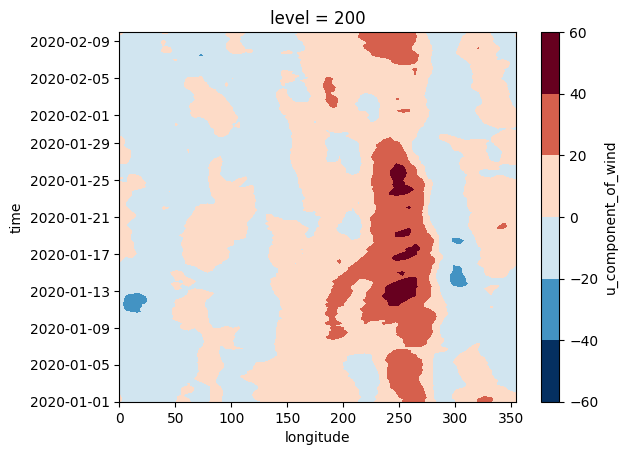

In [6]:
var = u.sel(level=200).sel(latitude = slice(-15,-5)).mean('latitude')
var.plot.contourf()

Play around with plotting.

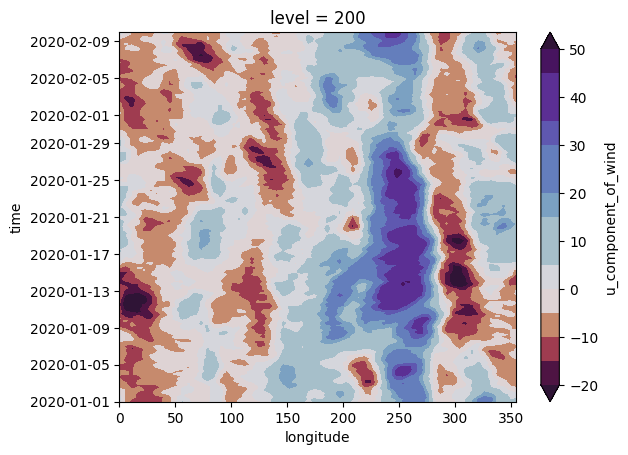

In [7]:
from matplotlib.colors import TwoSlopeNorm
divnorm = TwoSlopeNorm(vmin=-20., vcenter=0, vmax=50)

var.plot.contourf(cmap='twilight_shifted_r',
                  norm=divnorm,
                  levels=np.linspace(-20,50,15),
                  extend='both')

## 2. IFS forecast

In [9]:
ds = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr')
ds

<xarray.Dataset>
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2016-01-01 ... 2022-12-31...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

Now we see one more dimension of `prediction_timedelta` that indicates a forecast lead time.

In [10]:
ds.prediction_timedelta

<xarray.DataArray 'prediction_timedelta' (prediction_timedelta: 41)>
array([              0,  21600000000000,  43200000000000,  64800000000000,
        86400000000000, 108000000000000, 129600000000000, 151200000000000,
       172800000000000, 194400000000000, 216000000000000, 237600000000000,
       259200000000000, 280800000000000, 302400000000000, 324000000000000,
       345600000000000, 367200000000000, 388800000000000, 410400000000000,
       432000000000000, 453600000000000, 475200000000000, 496800000000000,
       518400000000000, 540000000000000, 561600000000000, 583200000000000,
       604800000000000, 626400000000000, 648000000000000, 669600000000000,
       691200000000000, 712800000000000, 734400000000000, 756000000000000,
       777600000000000, 799200000000000, 820800000000000, 842400000000000,
       864000000000000], dtype='timedelta64[ns]')
Coordinates:
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

In [11]:
#To select one-day forecast
u = ds['u_component_of_wind'].sel(prediction_timedelta = np.timedelta64(1, 'D'))

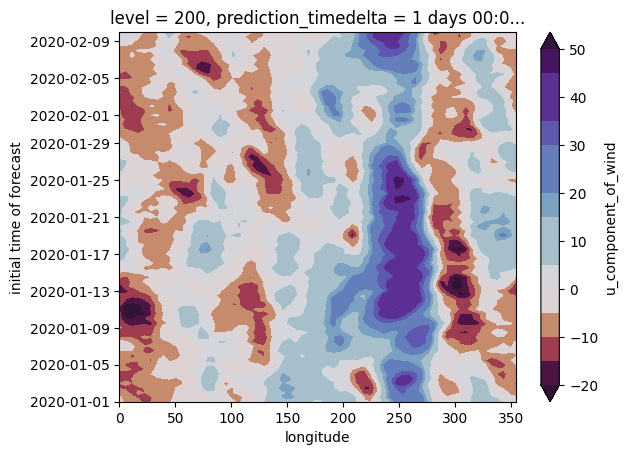

In [12]:
#Plot a hovmoeller digram of u from the one-day forecast
u = u.sel( time = slice(itime, ftime) )
var = u.sel(level=200).sel(latitude = slice(-15,-5)).mean('latitude')
var.plot.contourf(cmap='twilight_shifted_r',
                  norm=divnorm,
                  levels=np.linspace(-20,50,15),
                  extend='both')

## 3. Data-driven weather forecast model (Pangu-Weather)

In [13]:
ds = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')
ds

<xarray.Dataset>
Dimensions:                  (time: 3652, prediction_timedelta: 40,
                              longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int64 1000 925 850 700 ... 200 150 100 50
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 06:00:00 ...
  * time                     (time) datetime64[ns] 2018-01-01 ... 2022-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

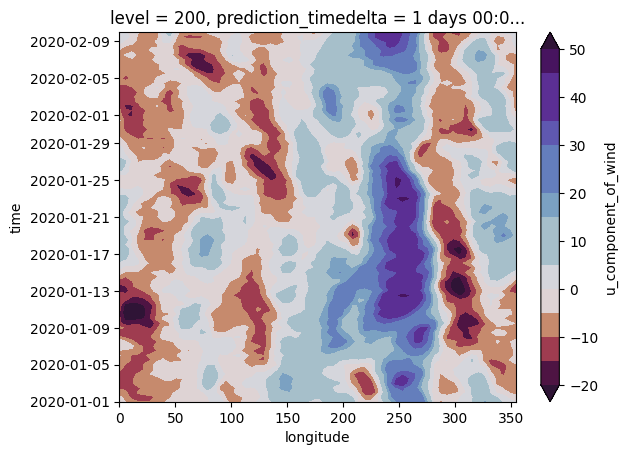

In [14]:
#To select one-day forecast
u = ds['u_component_of_wind'].sel(prediction_timedelta = np.timedelta64(1, 'D'))

#Plot a hovmoeller digram of u from the one-day forecast
u = u.sel( time = slice(itime, ftime) )
var = u.sel(level=200).sel(latitude = slice(-15,-5)).mean('latitude')
var.plot.contourf(cmap='twilight_shifted_r',
                  norm=divnorm,
                  levels=np.linspace(-20,50,15),
                  extend='both')

## Exercises

Now it is your turn to play around with the data.

1. Open a new jupyter notebook and repeats all the steps.

2. Plot one-day forecasts `u` from other data-driven weather forecast models.

|         Model       |                File               |
| :-------------------: | ------------------------------------------- |
|Keisler (2022)|`gs://weatherbench2/datasets/keisler/2020-64x32_equiangular_conservative.zarr`|
|GraphCast| `gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr`|
|Spherical CNN | `gs://weatherbench2/datasets/sphericalcnn/2020-64x32_equiangular_conservative.zarr`|
|FuXi| `gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr`|
|NeuralGCM|`gs://weatherbench2/datasets/neuralgcm_deterministic/2020-64x32_equiangular_conservative.zarr`|

You can find more information on [WeatherBench 2 Data Guide](https://weatherbench2.readthedocs.io/en/latest/data-guide.html). Note that not all data-driven models contain winds at 200 hPa.

3. Plot hovmoeller diagrams of `u` from all data-driven models together with ERA5 and IFS forecast. You may want to use `fig, axs = plt.subplots()`.

4. You can be more creative to explore data!